# DES Photometry Basics (ngmix, MOF, SOF)

Written by Spencer Everett

ECS Onboarding Workshop - Penn Collaboration Meeting, June 2019

In the [first demo](link!) we saw that MOF and SOF photometry don't always agree. We can identify this at the catalog level, but it's important to remember that the data we collect is fundamentaly _images_ and it's often important to start investigations and analyses at the image level.

This demo will help get you started in using Erin Sheldon's python package [ngmix](https://github.com/esheldon/ngmix) to render profiles from catalog fits as well as compare them to the actual images used to make the fits. The code that actually runs the fitting for a given `ngmix` profile is called [ngmixer](https://github.com/esheldon/ngmixer) if you'd like to take a look.

There's of course a lot of fun details that we're leaving out - the best places to get started are the [DES Y1 photometry paper](https://arxiv.org/abs/1708.01531), the [DESDM overview](https://des.ncsa.illinois.edu/releases/dr1/dr1-docs/processing), and the [DES science releases wiki page](https://cdcvs.fnal.gov/redmine/projects/des-sci-release/wiki). Or even better, ask people questions at coffee breaks, meals, and bars while you're at the meeting - DES folks are friendly and that's often how I learned!

In [1]:
# Our favorite packages!
import easyaccess as ea
import fitsio
import ngmix
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':14})

%matplotlib inline

# Connect to the database
connection=ea.connect()

Connecting to DB ** dessci ** ...
*Important* Last time password change was 607 days ago
 Please change it using the set_password command to get rid of this message



## Getting the data

As we saw in the first demo, there are a _lot_ (446) columns in `Y3_GOLD_2_2`. Let's grab only a few of the relevant MOF & SOF photometry columns that we will discuss in more detail later, in addition to some few generally useful info:

In [2]:
# Building a query...
com_cols = 'FLAGS_GOLD, COADD_OBJECT_ID, ' # Cols common to both types
mof_cols = 'mof_cm_fracdev, mof_cm_TdByTe, mof_cm_g_1, mof_cm_g_2, mof_cm_T, mof_cm_flux_i, MOF_CM_MAG_I, MOF_BOX_SIZE, '
sof_cols = 'sof_cm_fracdev, sof_cm_TdByTe, sof_cm_g_1, sof_cm_g_2, sof_cm_T, sof_cm_flux_i, SOF_CM_MAG_I, SOF_BOX_SIZE'

cols = com_cols + mof_cols + sof_cols

# % of catalog to randomly select (not fraction!)
percent = 0.001

query='select {} from Y3_GOLD_2_2 sample({})'.format(cols, percent)

data = connection.query_to_pandas(query)

Let's check the size of the catalog and that we grabbed the right columns:

In [3]:
data_size  = data.shape[0]
data_ncols = data.shape[1]
print('Shape: {}'.format(data.shape))
print('dtypes:\n{}'.format(data.dtypes))

Shape: (4022, 18)
dtypes:
FLAGS_GOLD           int64
COADD_OBJECT_ID      int64
MOF_CM_FRACDEV     float64
MOF_CM_TDBYTE      float64
MOF_CM_G_1         float64
MOF_CM_G_2         float64
MOF_CM_T           float64
MOF_CM_FLUX_I      float64
MOF_CM_MAG_I       float64
MOF_BOX_SIZE       float64
SOF_CM_FRACDEV     float64
SOF_CM_TDBYTE      float64
SOF_CM_G_1         float64
SOF_CM_G_2         float64
SOF_CM_T           float64
SOF_CM_FLUX_I      float64
SOF_CM_MAG_I       float64
SOF_BOX_SIZE         int64
dtype: object


## A couple cuts and note on `T`...

We now have all we need to render the ngmix photometry fits to these objects! However, we are unable to render certain objects whose fitting process failed - we can ignore these for the moment by using `FLAGS_GOLD` (MOF & SOF failures contribute the first and second bit flag to `FLAGS_GOLD` respectively):

In [4]:
print('There are {} objects before flag cut'.format(data_size))

data = data[data['FLAGS_GOLD']==0]

data_size  = data.shape[0]
data_ncols = data.shape[1]
print('There are {} objects after flag cut'.format(data_size))

There are 4022 objects before flag cut
There are 3802 objects after flag cut


Additionally, the visualizations in this demo will be a bit more interesting if we render medium-to-large objects. The PSF-deconvolved 'size' squared of each object is given by `T` which is in units of `arcsec^2`. Let's see the distribution for both MOF & SOF:

Text(0,0.5,u'Counts')

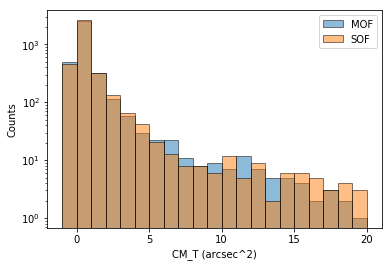

In [5]:
max_T = 20 # arcsec^2; goes out to 1e6 but vast majority are ~0-10

db = 1.
bins = np.arange(-db, max_T+db, db)

mof_T = data['MOF_CM_T'][data['MOF_CM_T'] < max_T]
sof_T = data['SOF_CM_T'][data['SOF_CM_T'] < max_T]

plt.hist(mof_T, bins=bins, ec='k', alpha=0.5, label='MOF')
plt.hist(sof_T, bins=bins, ec='k', alpha=0.5, label='SOF')
plt.legend()
plt.yscale('log')
plt.xlabel('CM_T (arcsec^2)')
plt.ylabel('Counts')

Note that a there's quite a few objects with negative T that passed our cuts - **that does not mean they are unphysical!** This has to do with complexities of `T` being a PSF-deconvolved size, and stars in particular will usually have negative `T~=-0.004`. In fact we can get a hint of this if we plot object's magnitudes vs `T`:

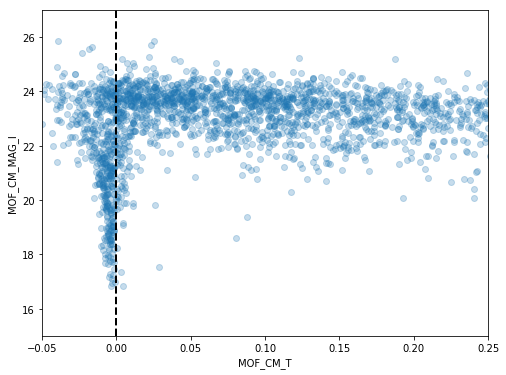

In [6]:
mof_imag = data['MOF_CM_MAG_I'][data['MOF_CM_T'] < max_T]

fig = plt.figure()
plt.scatter(mof_T, mof_imag, alpha=0.25)
plt.axvline(ls='--', lw=2, c='k')
plt.xlabel('MOF_CM_T')
plt.ylabel('MOF_CM_MAG_I')
plt.xlim(-0.05, 0.25)
plt.ylim(15, 27)
fig.set_size_inches(8, 6)

That spike of bright objects with slightly negative T are mostly stars. ** Note that this isn't actually how we handle star-galaxy classification** - just a quick aside as negative `T`s can be confusing. Look [here](https://cdcvs.fnal.gov/redmine/projects/des-y3/wiki/Y3_Extended_Classifier_v2) on the redmine wiki for more details on object classification.

Let's grab `T > 1` to make the renderings more interesting to look at:

In [7]:
print('There are {} objects before T-cut'.format(data_size))
tmin = 1
data = data[ (data['MOF_CM_T'] > tmin) &
             (data['SOF_CM_T'] > tmin) ]

data_size  = data.shape[0]
data_ncols = data.shape[1]
print('There are {} objects after T-cut'.format(data_size))

There are 3802 objects before T-cut
There are 647 objects after T-cut


## `ngmix` CModel Photometry

You'll notice that there's `CM` in all of the data column names. That stands for "Composite Model", which refers to a fitted galaxy profile that is a weighted sum of the best-fit "bulge" (de Vaucouleurs) and "disk" (exponential) profiles to the object which was inspired by the model used in SDSS. There are many other kinds of profile models you can use in `ngmix` that we won't get into here but you can check out [here](https://github.com/esheldon/ngmix/blob/master/ngmix/gmix.py#L1121) (or ask Erin Sheldon!)

All `ngmix` mixtures require an input called `pars` which contains offset, shape, size, and flux information passed in the following way:

`ngmix_pars = [offset_x, offset_y, g1, g2, T, flux]`

(Note that grabbing `pars` from a ngmix catalog will often have `flux` as an array of _all_ fluxes of that object, but these get flattened in DESDM catalogs.)

Some `ngmix` models require extra parameters including CModel. These are:

```
fracdev: The fraction of total flux in the de Vaucouleurs / bulge component
TdByTe : The ratio of bulge size (`Td`) to disk size (`Te`)
```

This accounts for most of the columns we requested from the database.

## Rendering object profiles from catalogs

We can render the MOF & SOF photometric fits using `ngmix.gmix`. Each fit is actually a Gaussian mixture approximation to a true profile (16 for CModel) and all of the necessary machinery is handled by `ngmix`. We simply need to initialize a `gmix.GMixCM` object with the parameters of an observed object and render with an appropriate image Jacobian (we will use a simple diagonal Jacobian for the demo that only sets the pixel scale).

In [8]:
# Pixelscale of DES images, needed for image Jacobians
pixscale = 0.2631

We will be making many renders, so let's put it in a function:

In [9]:
# A few useful tools for imshow subplots
from matplotlib.colors import LogNorm, Normalize
from mpl_toolkits.axes_grid1 import AxesGrid

def render_ngmix_obj(obj, vmin=0.5, vmax=1e4, size=5):
    '''obj is a np recarray containing phot info
       vmax sets the cmap saturation
       s sets fig size
    '''
    
    # NOTE: We don't care about image offsets in this case,
    # so we set them to 0 so both are perfectly centered
    
    # Grab MOF parameters
    mof_pars = [0,
                0,
                obj['MOF_CM_G_1'],
                obj['MOF_CM_G_2'],
                obj['MOF_CM_T'],
                obj['MOF_CM_FLUX_I']
               ]

    # Grab SOF parameters
    sof_pars = [0,
                0,
                obj['SOF_CM_G_1'],
                obj['SOF_CM_G_2'],
                obj['SOF_CM_T'],
                obj['SOF_CM_FLUX_I']
               ]

    # All GMix objects are set with `pars`, but CModel needs 
    # an additional 2
    mof_gm = ngmix.gmix.GMixCM(obj['MOF_CM_FRACDEV'],
                               obj['MOF_CM_TDBYTE'],
                               mof_pars)
    
    sof_gm = ngmix.gmix.GMixCM(obj['SOF_CM_FRACDEV'],
                               obj['SOF_CM_TDBYTE'],
                               sof_pars)
    
    # Set up image Jacobians with box dimensions and pixscale
    mof_dims = [obj['MOF_BOX_SIZE'], obj['MOF_BOX_SIZE']]
    mof_rc, mof_cc = (mof_dims[0]-1.0)/2.0, (mof_dims[1]-1.0)/2.0
    mof_jacob = ngmix.DiagonalJacobian(scale=pixscale, row=mof_rc, col=mof_cc)
    
    sof_dims = [obj['SOF_BOX_SIZE'], obj['SOF_BOX_SIZE']]
    sof_rc, sof_cc = (sof_dims[0]-1.0)/2.0, (sof_dims[1]-1.0)/2.0
    sof_jacob = ngmix.DiagonalJacobian(scale=pixscale, row=sof_rc, col=sof_cc)
    
    # Make image renders and plot them
    mof_im = mof_gm.make_image(mof_dims, jacobian=mof_jacob)
    sof_im = sof_gm.make_image(sof_dims, jacobian=sof_jacob)
    
    fig = plt.figure(figsize=(3*size, size))

    # AxesGrid is useful for setting cmap details on subplots 
    grid = AxesGrid(fig, 111,
                    nrows_ncols=(1, 3),
                    axes_pad=0.65,
                    cbar_mode='each',
                    cbar_location='right',
                    cbar_pad=0.1)
                    
    c = 0
    for ax in grid:
        if c == 0:
            data = mof_im
            ax.set_title('MOF CM Profile (i-band)')
            norm = LogNorm(vmin=vmin, vmax=vmax)
        elif c == 1:
            data = sof_im
            ax.set_title('SOF CM Profile (i-band)')
            norm = LogNorm(vmin=vmin, vmax=vmax)
        elif c == 2:
            data = mof_im - sof_im
            ax.set_title('Residual (MOF-SOF)')
            vmin = -1.2 * abs(np.floor(np.min(data)))
            vmax =  1.2 * abs(np.ceil(np.max(data)))
            norm = Normalize(vmin=vmin, vmax=vmax)
            
        im = ax.imshow(data, cmap='gray', origin='lower', norm=norm)
    
        cbar = ax.cax.colorbar(im)
        cbar = grid.cbar_axes[c].colorbar(im)
        
        c += 1
        
    obj_id = obj['COADD_OBJECT_ID']
    fig.suptitle('COADD_OBJECT_ID={}'.format(obj_id))
    
    plt.show()
    
    return

Let's start with a random object that passed our cuts:

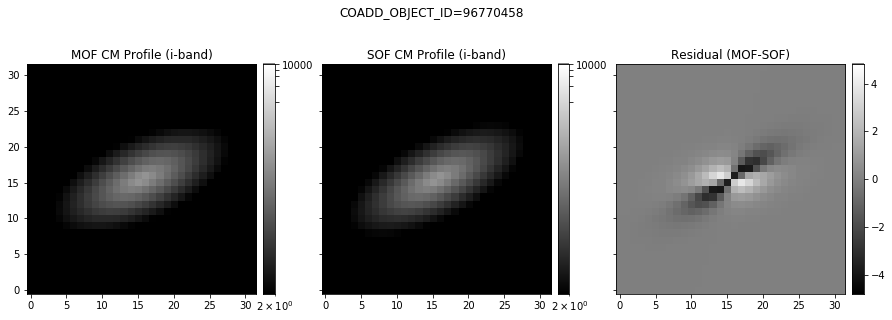

In [10]:
# It'll be easier to work with a np rec array for this
obj = data.sample().to_records()[0]

render_ngmix_obj(obj, vmin=0.5, vmax=10000)

(If produced images look strange, you may have gotten unlucky. Rerun the cell)

Depending on the random object selected you may see a variety of things. But you almost certainly have discovered that there are noticeable differences in the rendered MOF & SOF images, at least in the residual if not by eye.

The reasons behind the differences are numerous, from small effects like fitting initialization noise to fundamental algorithmic differences in how the methods deal with light from nearby objects (SOF simply masks them, while MOF models the neighbor light and subtracts it).

Here's an example I found when making this demo:
![title](mof_sof_compare_example.png)
A slight change in preferred orientation between the fits is a possible explanation, but we'd have to explore the object in more detail to know for sure.

It's hard to get a good feel for this from one comparison. So let's make a series of 10:

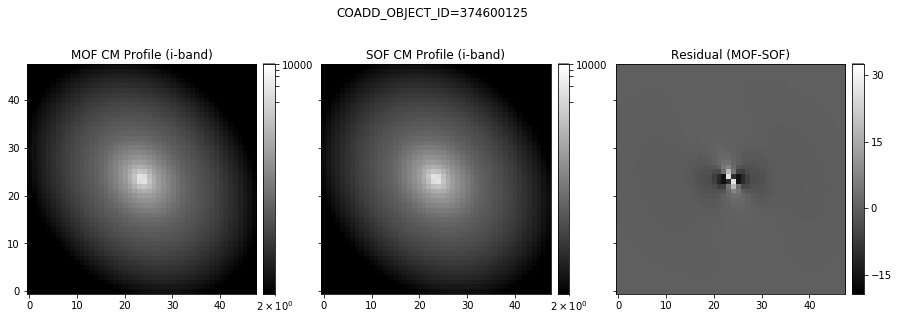

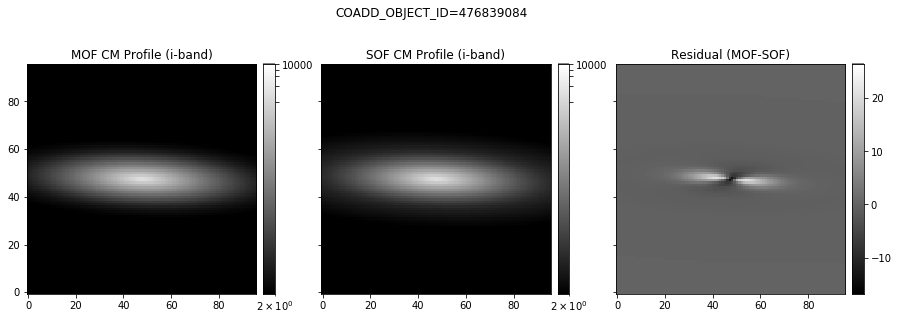

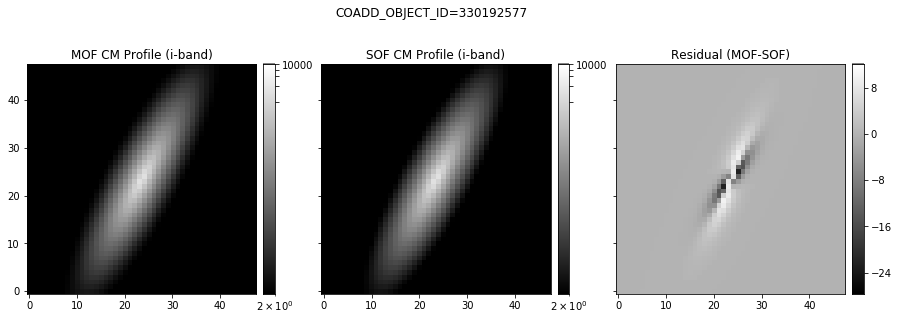

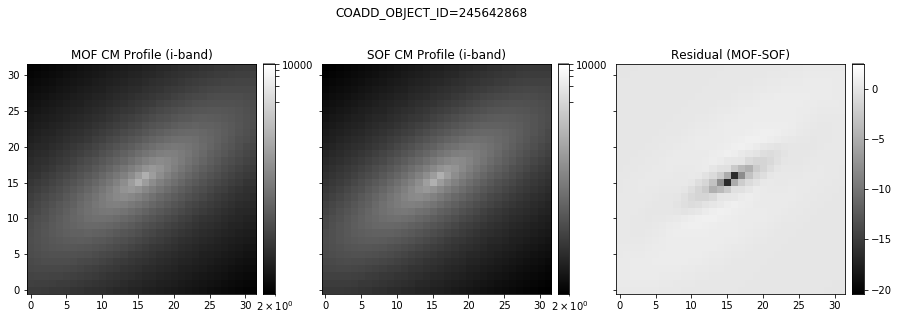

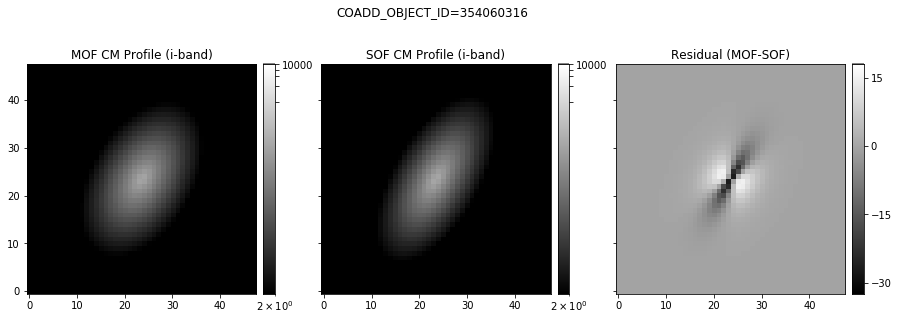

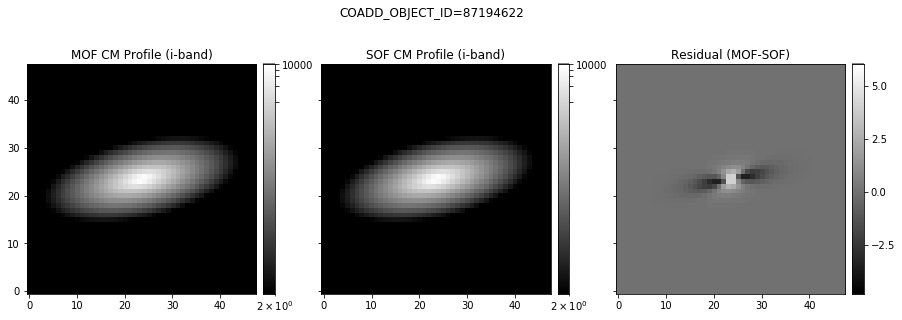

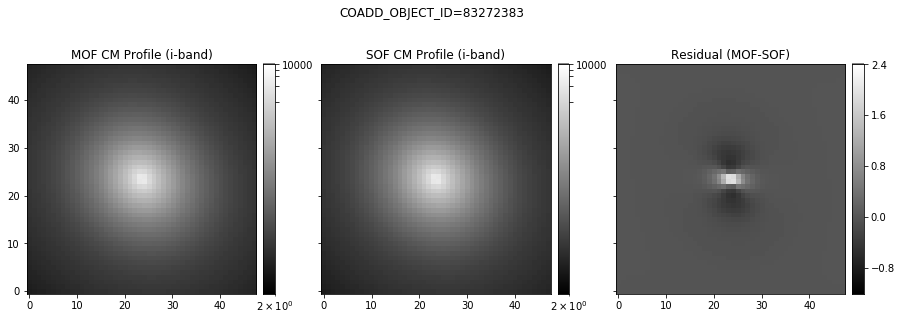

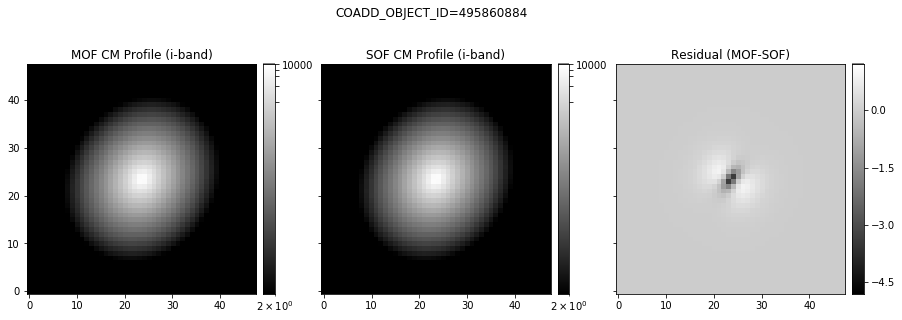

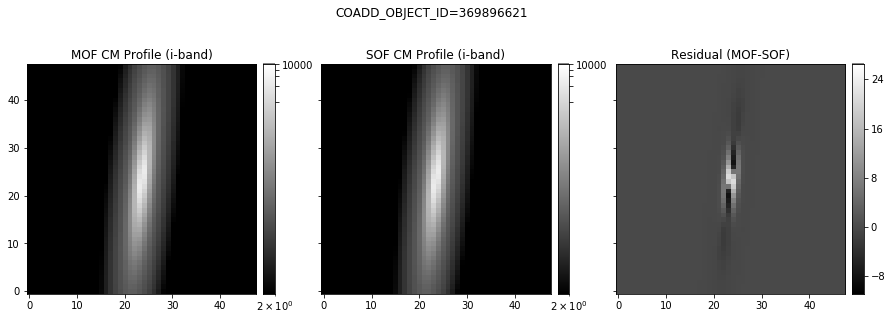

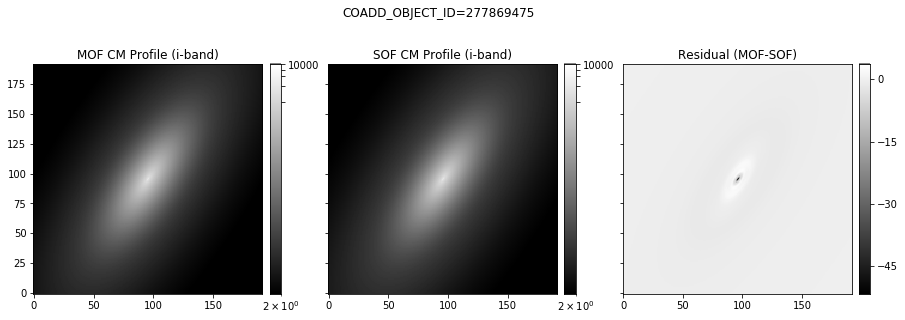

In [11]:
# Number of objects we'll render & compare
Nobjs = 10

for obj in data.sample(Nobjs).to_records():
    render_ngmix_obj(obj)

These have been comparisons of the estimated 'true' profiles after accounting for the effects of PSFs. If you'd like to render these objects convolved with a simulated PSF to make them look closer to an 'observation' that would be present in the images, we can modify our original `render_ngmix_obj()` function like the following:

In [12]:
def render_ngmix_obj_psf(obj, vmin=0.5, vmax=1e4, size=5, psf_T=0.5):
    '''obj is a np recarray containing phot info
       vmax sets the cmap saturation
       s sets fig size
       psf_T is T-size of PSF
    '''
    
    # NOTE: We don't care about image offsets in this case,
    # so we set them to 0 so both are perfectly centered
    
    # Grab MOF parameters
    mof_pars = [0,
                0,
                obj['MOF_CM_G_1'],
                obj['MOF_CM_G_2'],
                obj['MOF_CM_T'],
                obj['MOF_CM_FLUX_I']
               ]

    # Grab SOF parameters
    sof_pars = [0,
                0,
                obj['SOF_CM_G_1'],
                obj['SOF_CM_G_2'],
                obj['SOF_CM_T'],
                obj['SOF_CM_FLUX_I']
               ]

    # All GMix objects are set with `pars`, but CModel needs 
    # an additional 2
    mof_gm = ngmix.gmix.GMixCM(obj['MOF_CM_FRACDEV'],
                               obj['MOF_CM_TDBYTE'],
                               mof_pars)
    
    sof_gm = ngmix.gmix.GMixCM(obj['SOF_CM_FRACDEV'],
                               obj['SOF_CM_TDBYTE'],
                               sof_pars)
    
    #-----------------------------------------------------------------------------
    # Needed PSF additions
    
    # We'll model PSF as a single gaussian w/ unit flux
    psf_pars = [0.0, 0.0, 0.0, 0.0, psf_T, 1.0]
    psf_gm = ngmix.GMixModel(psf_pars, 'gauss')
    
    # Convolution with the PSF & CM profiles
    mof_gm = mof_gm.convolve(psf_gm)
    sof_gm = sof_gm.convolve(psf_gm)
    #-----------------------------------------------------------------------------

    # Set up image Jacobians with box dimensions and pixscale
    mof_dims = [obj['MOF_BOX_SIZE'], obj['MOF_BOX_SIZE']]
    mof_rc, mof_cc = (mof_dims[0]-1.0)/2.0, (mof_dims[1]-1.0)/2.0
    mof_jacob = ngmix.DiagonalJacobian(scale=pixscale, row=mof_rc, col=mof_cc)
    
    sof_dims = [obj['SOF_BOX_SIZE'], obj['SOF_BOX_SIZE']]
    sof_rc, sof_cc = (sof_dims[0]-1.0)/2.0, (sof_dims[1]-1.0)/2.0
    sof_jacob = ngmix.DiagonalJacobian(scale=pixscale, row=sof_rc, col=sof_cc)
    
    # Make image renders and plot them
    mof_im = mof_gm.make_image(mof_dims, jacobian=mof_jacob)
    sof_im = sof_gm.make_image(sof_dims, jacobian=sof_jacob)
    
    fig = plt.figure(figsize=(3*size, size))

    # AxesGrid is useful for setting cmap details on subplots 
    grid = AxesGrid(fig, 111,
                    nrows_ncols=(1, 3),
                    axes_pad=0.65,
                    cbar_mode='each',
                    cbar_location='right',
                    cbar_pad=0.1)
                    
    c = 0
    for ax in grid:
        if c == 0:
            data = mof_im
            ax.set_title('MOF CM Profile (i-band)')
            norm = LogNorm(vmin=vmin, vmax=vmax)
        elif c == 1:
            data = sof_im
            ax.set_title('SOF CM Profile (i-band)')
            norm = LogNorm(vmin=vmin, vmax=vmax)
        elif c == 2:
            data = mof_im - sof_im
            ax.set_title('Residual (MOF-SOF)')
            vmin = -1.2 * abs(np.floor(np.min(data)))
            vmax =  1.2 * abs(np.ceil(np.max(data)))
            norm = Normalize(vmin=vmin, vmax=vmax)
            
        im = ax.imshow(data, cmap='gray', origin='lower', norm=norm)
    
        cbar = ax.cax.colorbar(im)
        cbar = grid.cbar_axes[c].colorbar(im)
        
        c += 1
        
    obj_id = obj['COADD_OBJECT_ID']
    fig.suptitle('COADD_OBJECT_ID={}'.format(obj_id))
    
    plt.show()
    
    return

Now render the profiles convolved with PSF. The residuals with strong multipoles are partially due to our not-very-realistic PSF model:

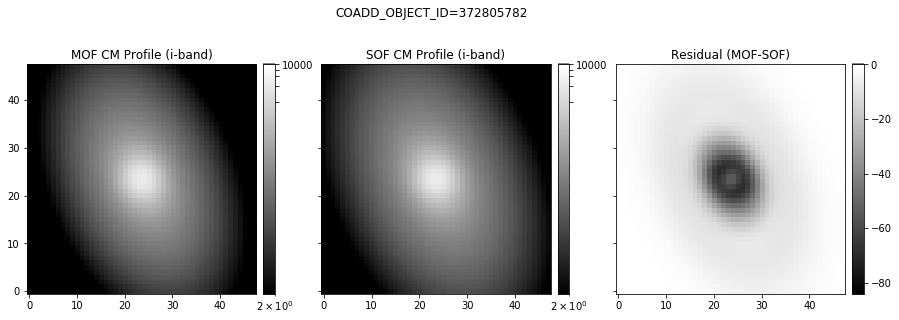

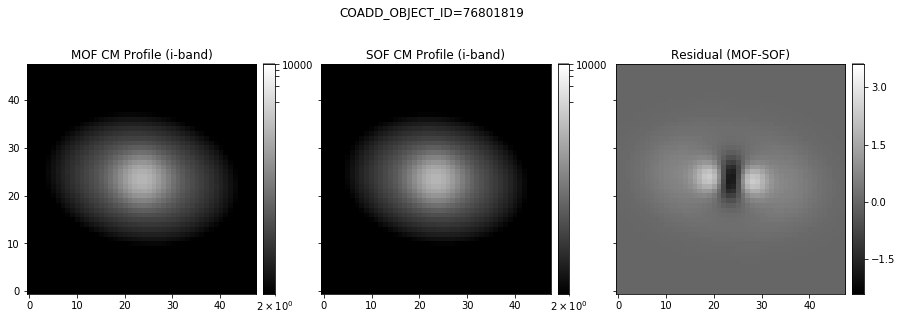

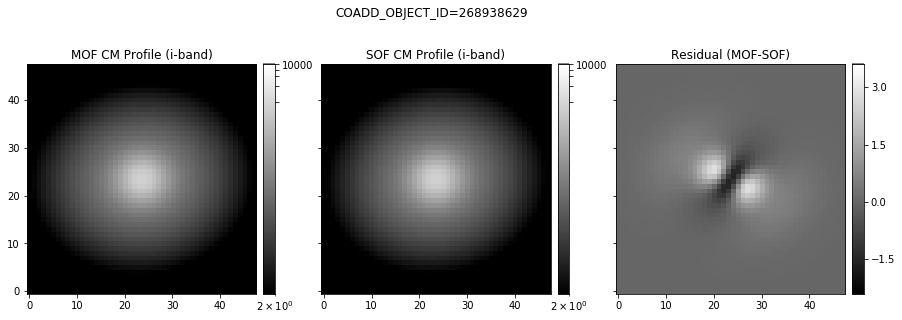

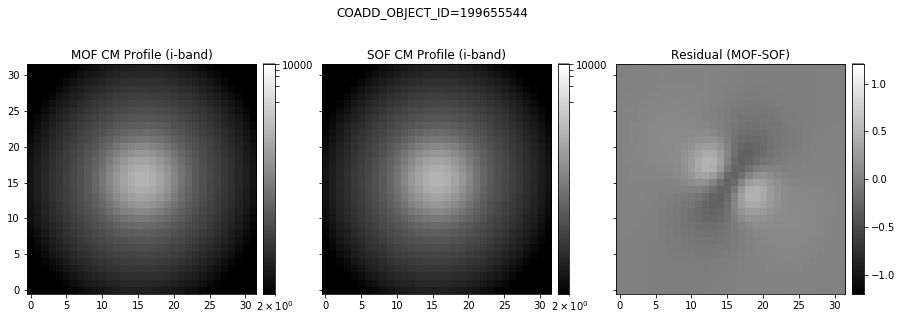

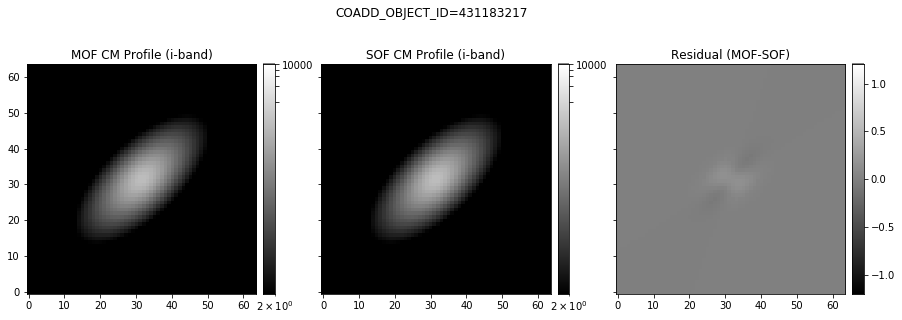

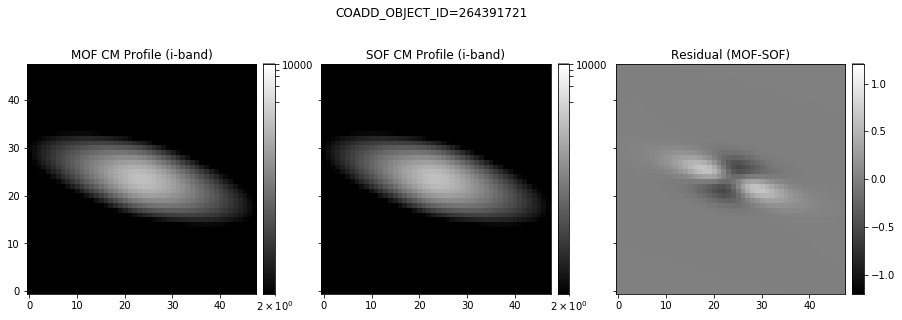

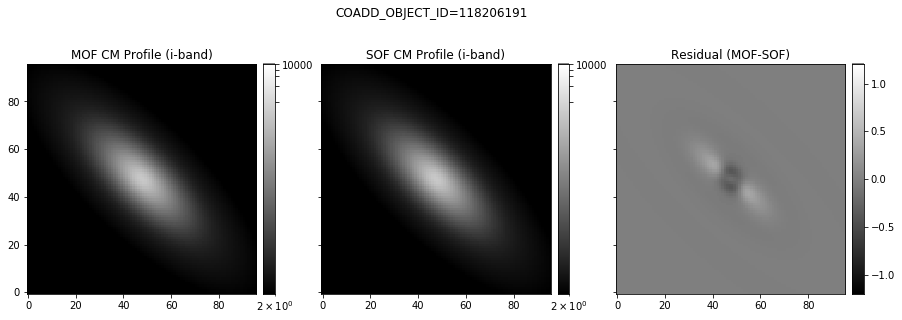

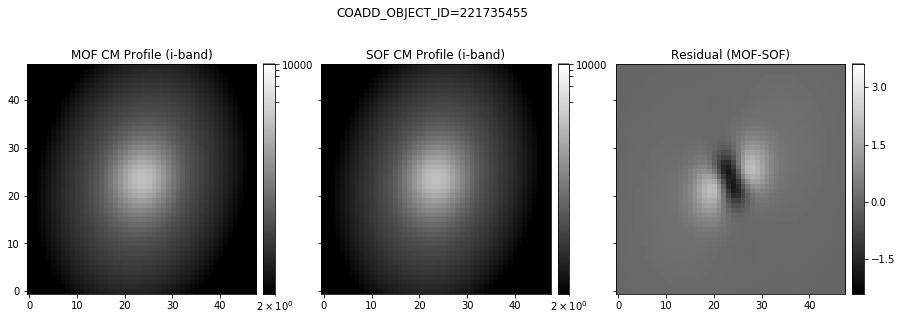

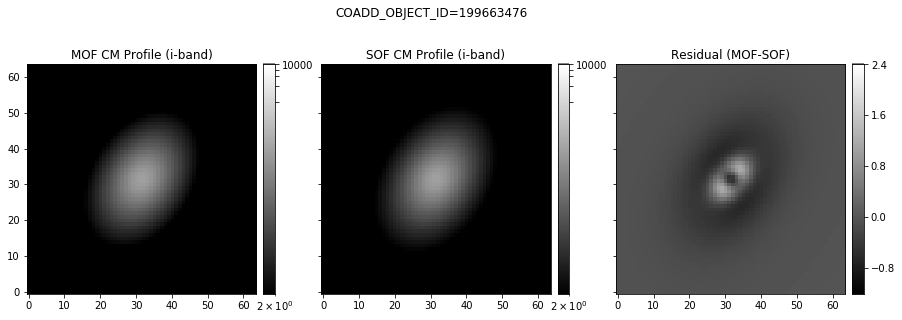

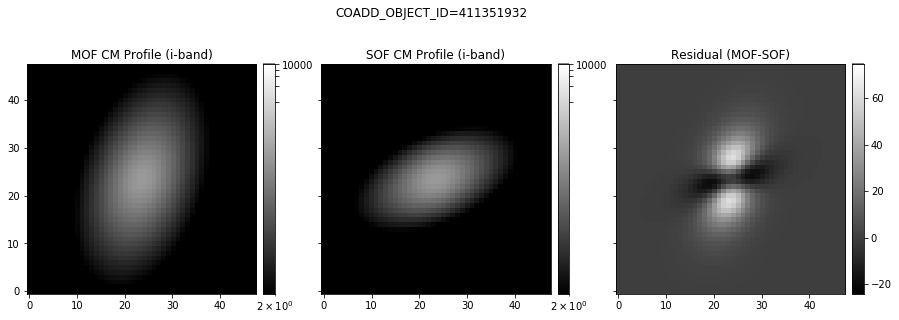

In [13]:
# Play around with the PSF size
psf_T = 0.5

for obj in data.sample(Nobjs).to_records():
    render_ngmix_obj_psf(obj, psf_T=psf_T)

## Comparing to real images (Under construction)

We've already learned an important lesson; photometry is hard, don't simply trust catalog data as truth! Different choices can sometimes lead to quite different results for an individual object. It's all about quantifying uncertainties, working with large populations, and spending lots of time identifying systematics from those choices.

## A few suggestions for things to try:

- Grab a sample of galaxies near a large cluster from the DB instead of randomly. Should the comparison of MOF & SOF be better, worse, or the same?
- There is a lot of current work with using a `BDF` profile rather than `CM` for future photometry, which is like CModel except it removes the ratios between bulge and disk as free parameters which increases stability. Look at the residuals between objects rendered with `gmix.GMIXCM` and `gmix.GMixBDF` ([documentation here](https://github.com/esheldon/ngmix/blob/master/ngmix/gmix.py#L935), only needs to pass `pars`). This is a bit contrived as you really want to compare the profiles that were _fit_ with CM vs BDF, but it will give you some practice with different gmix types
- more...